In [1]:
from google.colab import files

uploaded = files.upload()

Saving techniques-classification.parquet to techniques-classification (1).parquet


In [2]:
!pip install torch transformers pandas numpy scikit-learn fastparquet > /dev/null 2>&1

# Base XLM-RoBERTa multi-label classification

## 1 Dependencies

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score,
    f1_score, accuracy_score
)

import ast

## 2 Seeds and Device

In [4]:
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 3 Dataset for manipulating techniques

In [5]:
class ManipulationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, techniques, tokenizer, max_len=512):
        self.texts = texts
        self.techniques = techniques
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Create label encoder
        self.unique_techniques = sorted(list(set(
            technique
            for techniques_list in self.techniques
            for technique in (ast.literal_eval(techniques_list) if isinstance(techniques_list, str)
                                                                else techniques_list.tolist()
                                                                if hasattr(techniques_list, 'tolist')
                                                                else techniques_list or [])
        )))
        self.technique_to_idx = {technique: idx for idx, technique in enumerate(self.unique_techniques)}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])

        # Convert techniques to multi-hot encoding
        techniques = self.techniques[item]
        if isinstance(techniques, str):
            techniques = ast.literal_eval(techniques)

        label = torch.zeros(len(self.unique_techniques))
        if techniques is not None and len(techniques) > 0:
            for technique in techniques:
                label[self.technique_to_idx[technique]] = 1

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }

## 4 Load Dataset

In [6]:
tokenizer = AutoTokenizer.from_pretrained('youscan/ukr-roberta-base')

df = pd.read_parquet('/content/techniques-classification.parquet')

df = df[df["lang"] == "uk"]

train_df, val_df = train_test_split(df, test_size=0.2)

train_dataset = ManipulationDataset(train_df['content'].values, train_df['techniques'].values, tokenizer)
val_dataset = ManipulationDataset(val_df['content'].values, val_df['techniques'].values, tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## 5 Model preparation

In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.sigmoid(torch.tensor(logits)) > 0.5

    # Обчислення метрик
    precision = precision_score(labels, preds, average='micro')
    recall = recall_score(labels, preds, average='micro')
    f1 = f1_score(labels, preds, average='micro')
    accuracy = accuracy_score(labels, preds)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
    }

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(
    'youscan/ukr-roberta-base',
    num_labels=len(train_dataset.unique_techniques),
    problem_type="multi_label_classification"
).to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir='checkpoints',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='logs',
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    save_total_limit=2,
    logging_steps=100
)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at youscan/ukr-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-a66c72b033f6>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## 6 Train Model

In [9]:
%%time

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: yarinko-b (yarinko-bohdan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.297400,0.249860,0.715152,0.253219,0.374010,0.402326
2,0.240900,0.226014,0.701107,0.407725,0.515604,0.472093
3,0.209400,0.223196,0.695035,0.420601,0.524064,0.483721
4,0.187100,0.247333,0.705179,0.379828,0.493724,0.460465
5,0.160600,0.241752,0.634349,0.491416,0.553809,0.427907
6,0.138600,0.252996,0.664615,0.463519,0.546144,0.439535
7,0.120600,0.270250,0.631436,0.500000,0.558084,0.441860
8,0.106600,0.279187,0.643917,0.465665,0.540473,0.453488
9,0.093500,0.285679,0.643077,0.448498,0.528445,0.451163
10,0.078000,0.289111,0.620419,0.508584,0.558962,0.439535


CPU times: user 56min 53s, sys: 58.3 s, total: 57min 51s
Wall time: 1h 4min 28s


TrainOutput(global_step=2160, training_loss=0.0903861144626582, metrics={'train_runtime': 3867.7709, 'train_samples_per_second': 8.878, 'train_steps_per_second': 0.558, 'total_flos': 9035882630799360.0, 'train_loss': 0.0903861144626582, 'epoch': 20.0})

In [ ]:
evaluation_feedback = trainer.evaluate()

## 7 Save Model

In [ ]:
trainer.save_model("models")
tokenizer.save_pretrained("models")


## 8 Metrics Visualisation

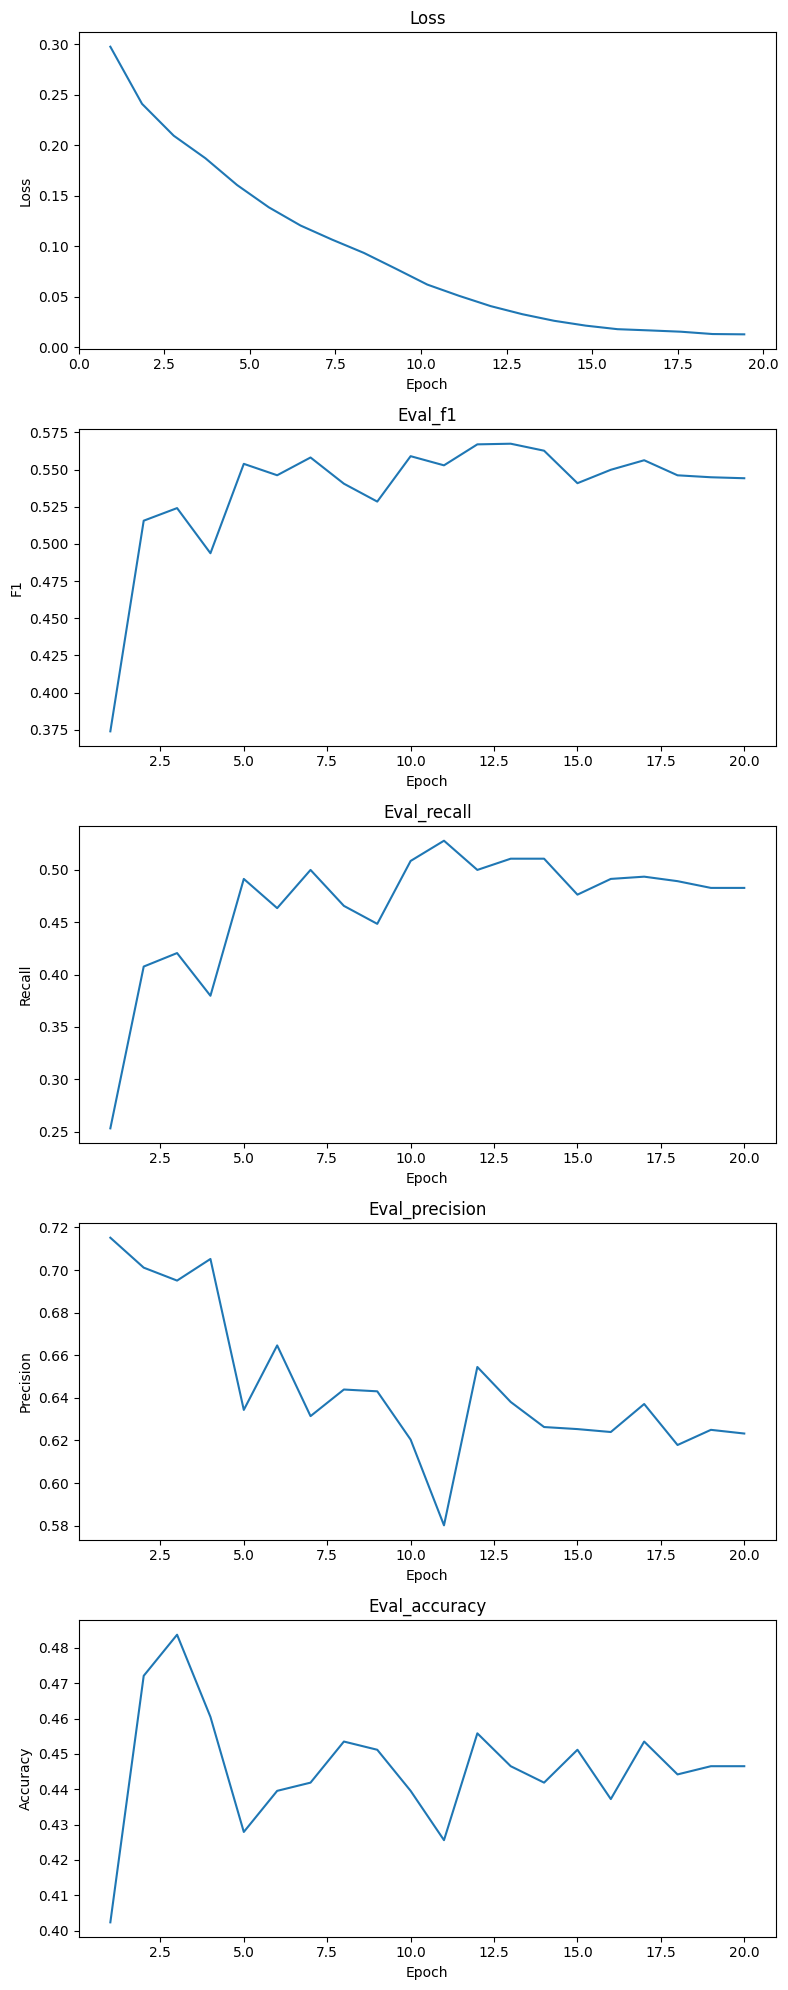

In [10]:
logs = trainer.state.log_history

# Metrics with corresponding epochs
metrics = ['loss', 'eval_f1', 'eval_recall', 'eval_precision', 'eval_accuracy']
data = {}
for metric in metrics:
    data[metric] = {'values': [], 'epochs': []}
    for log in logs:
        if metric in log:
            data[metric]['values'].append(log[metric])
            data[metric]['epochs'].append(log['epoch'])

# Plots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, 4 * len(metrics)))

for i, metric in enumerate(metrics):
    axes[i].plot(data[metric]['epochs'], data[metric]['values'])
    axes[i].set_title(metric.capitalize())
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(metric.replace('eval_', '').capitalize())

plt.tight_layout()
plt.show()

## 9 Test

In [ ]:
def predict(text, model, tokenizer, unique_techniques):
    model.eval()
    model.to(device)
    encoding = tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(encoding['input_ids'], encoding['attention_mask']).logits
        predictions = torch.sigmoid(outputs) > 0.5

    predicted_techniques = [unique_techniques[i] for i, pred in enumerate(predictions[0]) if pred]
    return predicted_techniques

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("/content/models")
tokenizer = AutoTokenizer.from_pretrained("/content/models")

text_to_predict = "Уничтожение ВСУшников в Бахмуте артиллерией «Вагнер»"

unique_techniques = train_dataset.unique_techniques
predicted_techniques = predict(text_to_predict, model, tokenizer, unique_techniques)
predicted_techniques

['euphoria', 'loaded_language']

In [ ]:
!zip -r /content/checkpoints.zip /content/checkpoints
!zip -r /content/logs.zip /content/logs
!zip -r /content/models.zip /content/models

  adding: content/checkpoints/ (stored 0%)
  adding: content/checkpoints/checkpoint-1915/ (stored 0%)
  adding: content/checkpoints/checkpoint-1915/training_args.bin (deflated 52%)
  adding: content/checkpoints/checkpoint-1915/vocab.txt (deflated 45%)
  adding: content/checkpoints/checkpoint-1915/config.json (deflated 59%)
  adding: content/checkpoints/checkpoint-1915/tokenizer_config.json (deflated 75%)
  adding: content/checkpoints/checkpoint-1915/optimizer.pt (deflated 51%)
  adding: content/checkpoints/checkpoint-1915/trainer_state.json (deflated 72%)
  adding: content/checkpoints/checkpoint-1915/model.safetensors (deflated 7%)
  adding: content/checkpoints/checkpoint-1915/tokenizer.json (deflated 67%)
  adding: content/checkpoints/checkpoint-1915/scheduler.pt (deflated 56%)
  adding: content/checkpoints/checkpoint-1915/rng_state.pth (deflated 25%)
  adding: content/checkpoints/checkpoint-1915/special_tokens_map.json (deflated 42%)
  adding: content/checkpoints/checkpoint-4979/ (st